Data Shape: (21263, 82)

First 5 rows:
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                

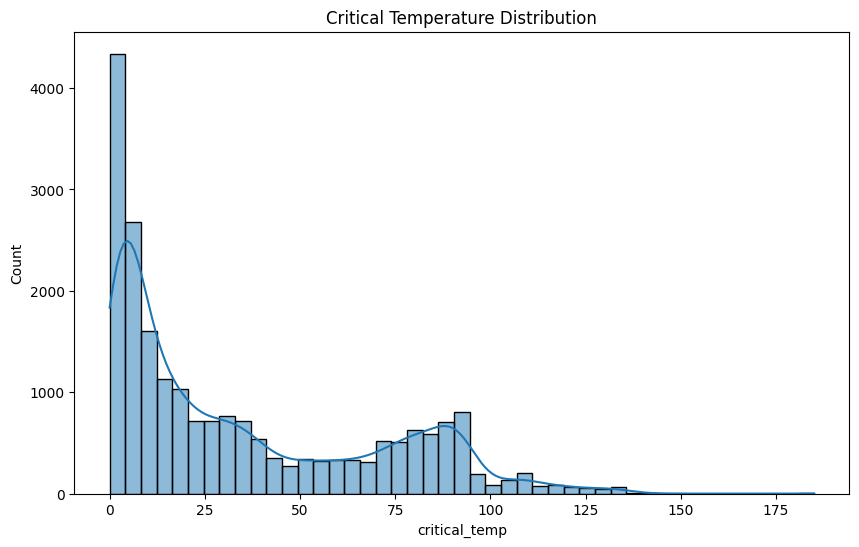


Top 10 Correlated Features:
critical_temp                  1.000000
wtd_std_ThermalConductivity    0.721271
range_ThermalConductivity      0.687654
range_atomic_radius            0.653759
std_ThermalConductivity        0.653632
wtd_entropy_atomic_mass        0.626930
wtd_entropy_atomic_radius      0.603494
number_of_elements             0.601069
range_fie                      0.600790
wtd_std_atomic_radius          0.599199
Name: critical_temp, dtype: float64


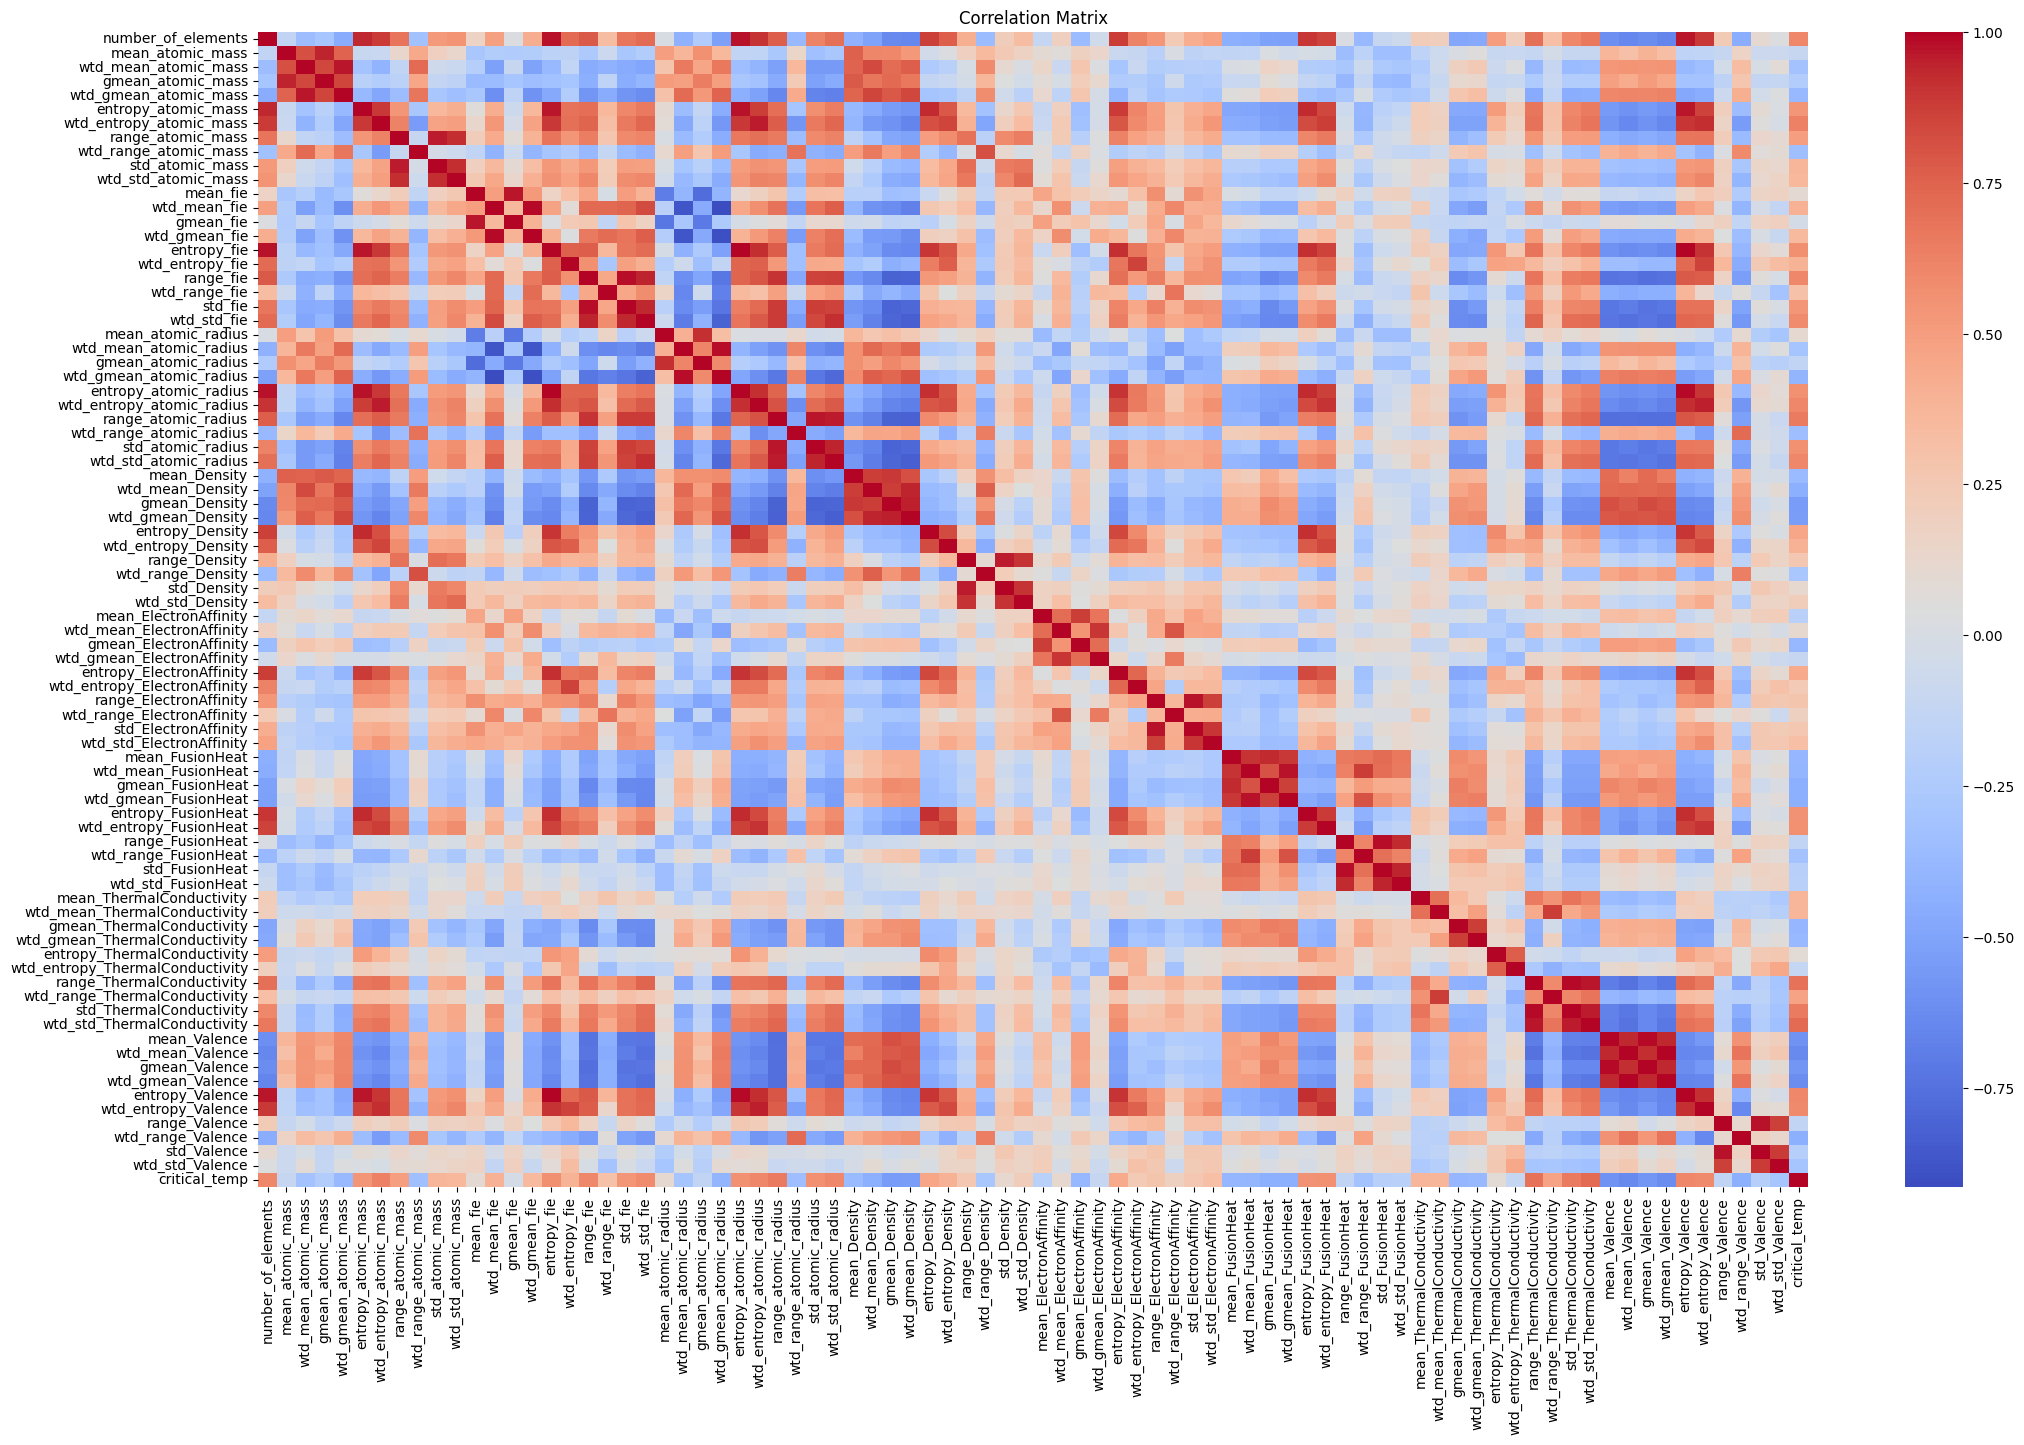


Selected Features:
Index(['entropy_atomic_mass', 'range_fie', 'std_fie', 'entropy_atomic_radius',
       'std_atomic_radius', 'gmean_Density', 'entropy_Density',
       'range_Density', 'gmean_ElectronAffinity', 'entropy_ElectronAffinity',
       'range_ElectronAffinity', 'std_ElectronAffinity', 'mean_FusionHeat',
       'gmean_FusionHeat', 'entropy_FusionHeat', 'mean_ThermalConductivity',
       'gmean_ThermalConductivity', 'std_ThermalConductivity',
       'wtd_mean_Valence', 'wtd_gmean_Valence'],
      dtype='object')

Cross-Validation Results:
                               RMSE       Std        R2
Random Forest             11.332425  0.062358  0.891011
XGBoost                   11.445652  0.197910  0.888791
Gradient Boosting         14.509971  0.136403  0.821300
Support Vector Regressor  19.109376  0.177155  0.690087
Linear Regression         21.251246  0.171796  0.616727
Ridge Regression          21.251440  0.172911  0.616720
Lasso Regression          23.367994  0.206680  0.5365

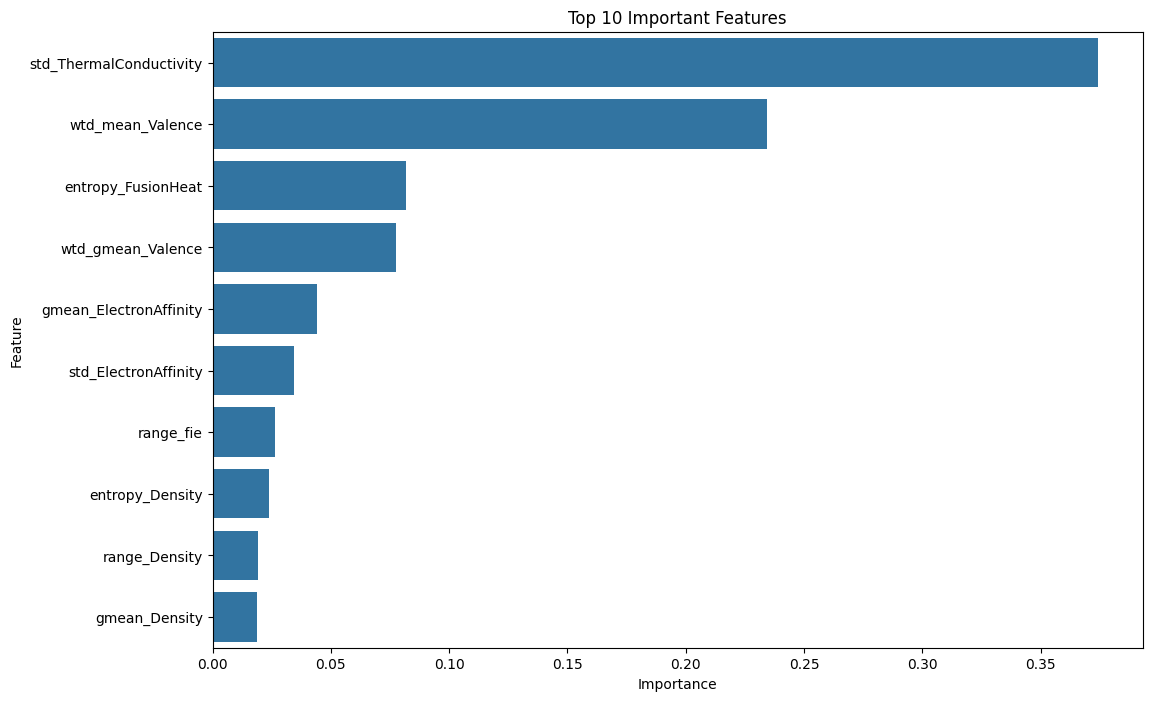

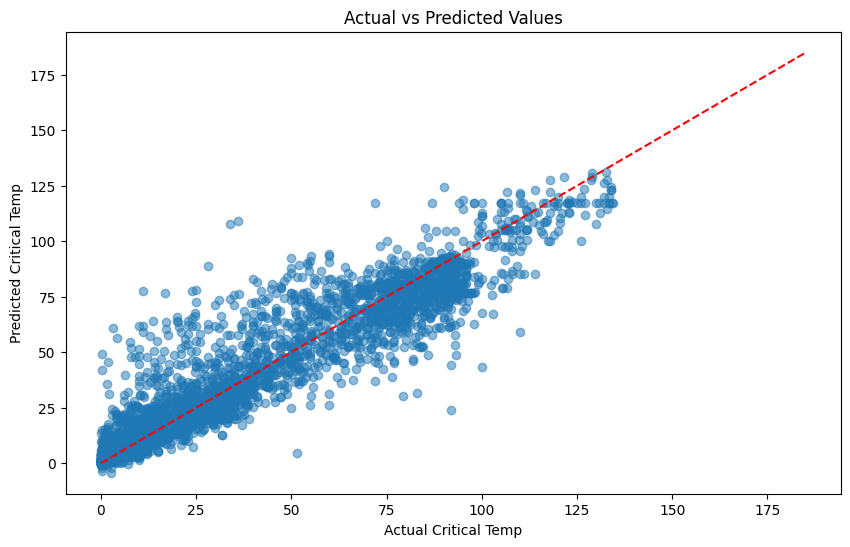

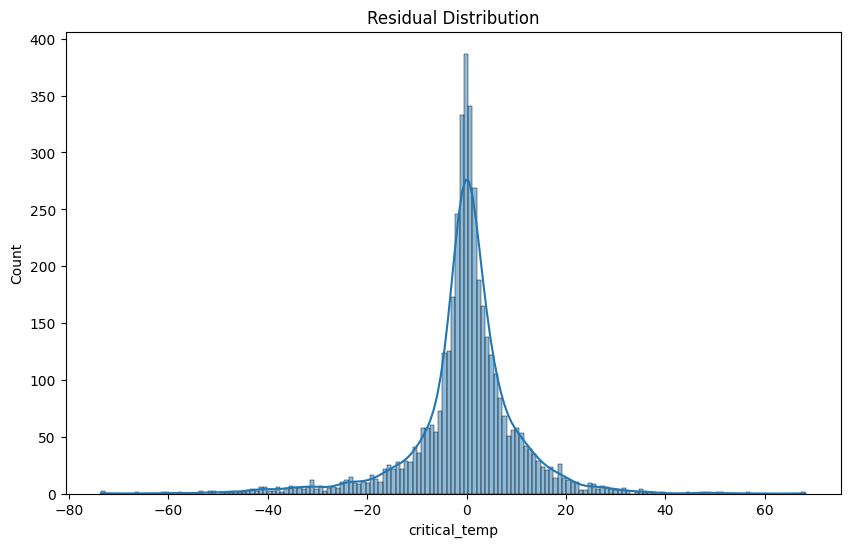

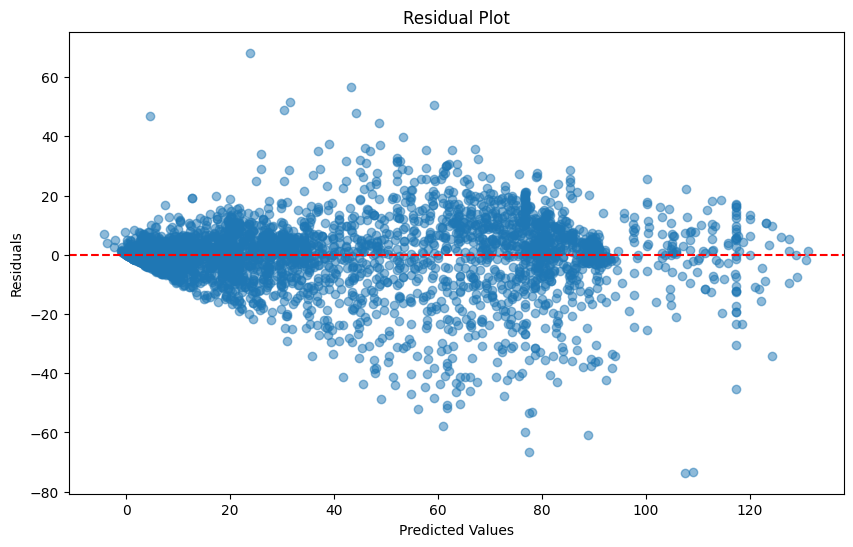

In [2]:
# %% Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# %% Load and Inspect Data
df = pd.read_csv('Superconductor.csv')
print("Data Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData Summary:")
print(df.describe())

# %% Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum().sum())  # Should be 0 based on sample data

# %% Exploratory Data Analysis
# Target Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['critical_temp'], kde=True)
plt.title('Critical Temperature Distribution')
plt.show()

# Correlation Analysis
corr_matrix = df.corr()
target_corr = corr_matrix['critical_temp'].sort_values(ascending=False)
print("\nTop 10 Correlated Features:")
print(target_corr.head(10))

plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# %% Feature Selection
X = df.drop('critical_temp', axis=1)
y = df['critical_temp']

# Select top 20 features using Mutual Information
selector = SelectKBest(score_func=mutual_info_regression, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("\nSelected Features:")
print(selected_features)

# Update X with selected features
X = X[selected_features]

# %% Data Preprocessing
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# %% Initialize Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR(),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# %% Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=cv, scoring='neg_root_mean_squared_error'
    )
    results[name] = {
        'RMSE': (-cv_scores).mean(),
        'Std': cv_scores.std(),
        'R2': cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='r2').mean()
    }

cv_results = pd.DataFrame(results).T.sort_values('RMSE')
print("\nCross-Validation Results:")
print(cv_results)

# %% Model Evaluation
final_results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    final_results.append({
        'Model': name,
        'RMSE': rmse,
        'R2 Score': r2
    })

results_df = pd.DataFrame(final_results).sort_values('RMSE')
print("\nTest Set Performance:")
print(results_df)

# %% Feature Importance (Best Model)
best_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train_scaled, y_train)

importances = best_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features')
plt.show()

# %% Visualization of Predictions
best_model = models[results_df.iloc[0]['Model']]
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Actual Critical Temp')
plt.ylabel('Predicted Critical Temp')
plt.title('Actual vs Predicted Values')
plt.show()

# %% Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Initial Data Overview:
Shape: (21263, 82)

Data Types:
float64    79
int64       3
Name: count, dtype: int64

Missing Values:
0


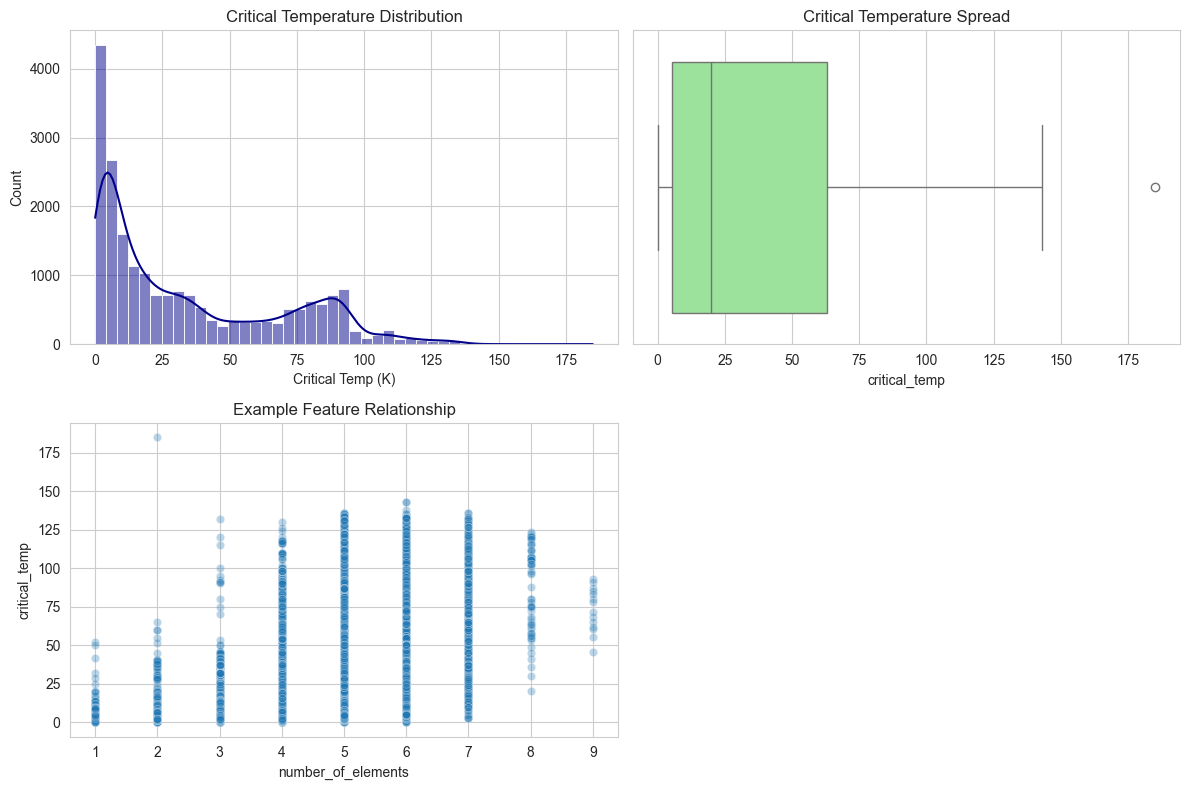

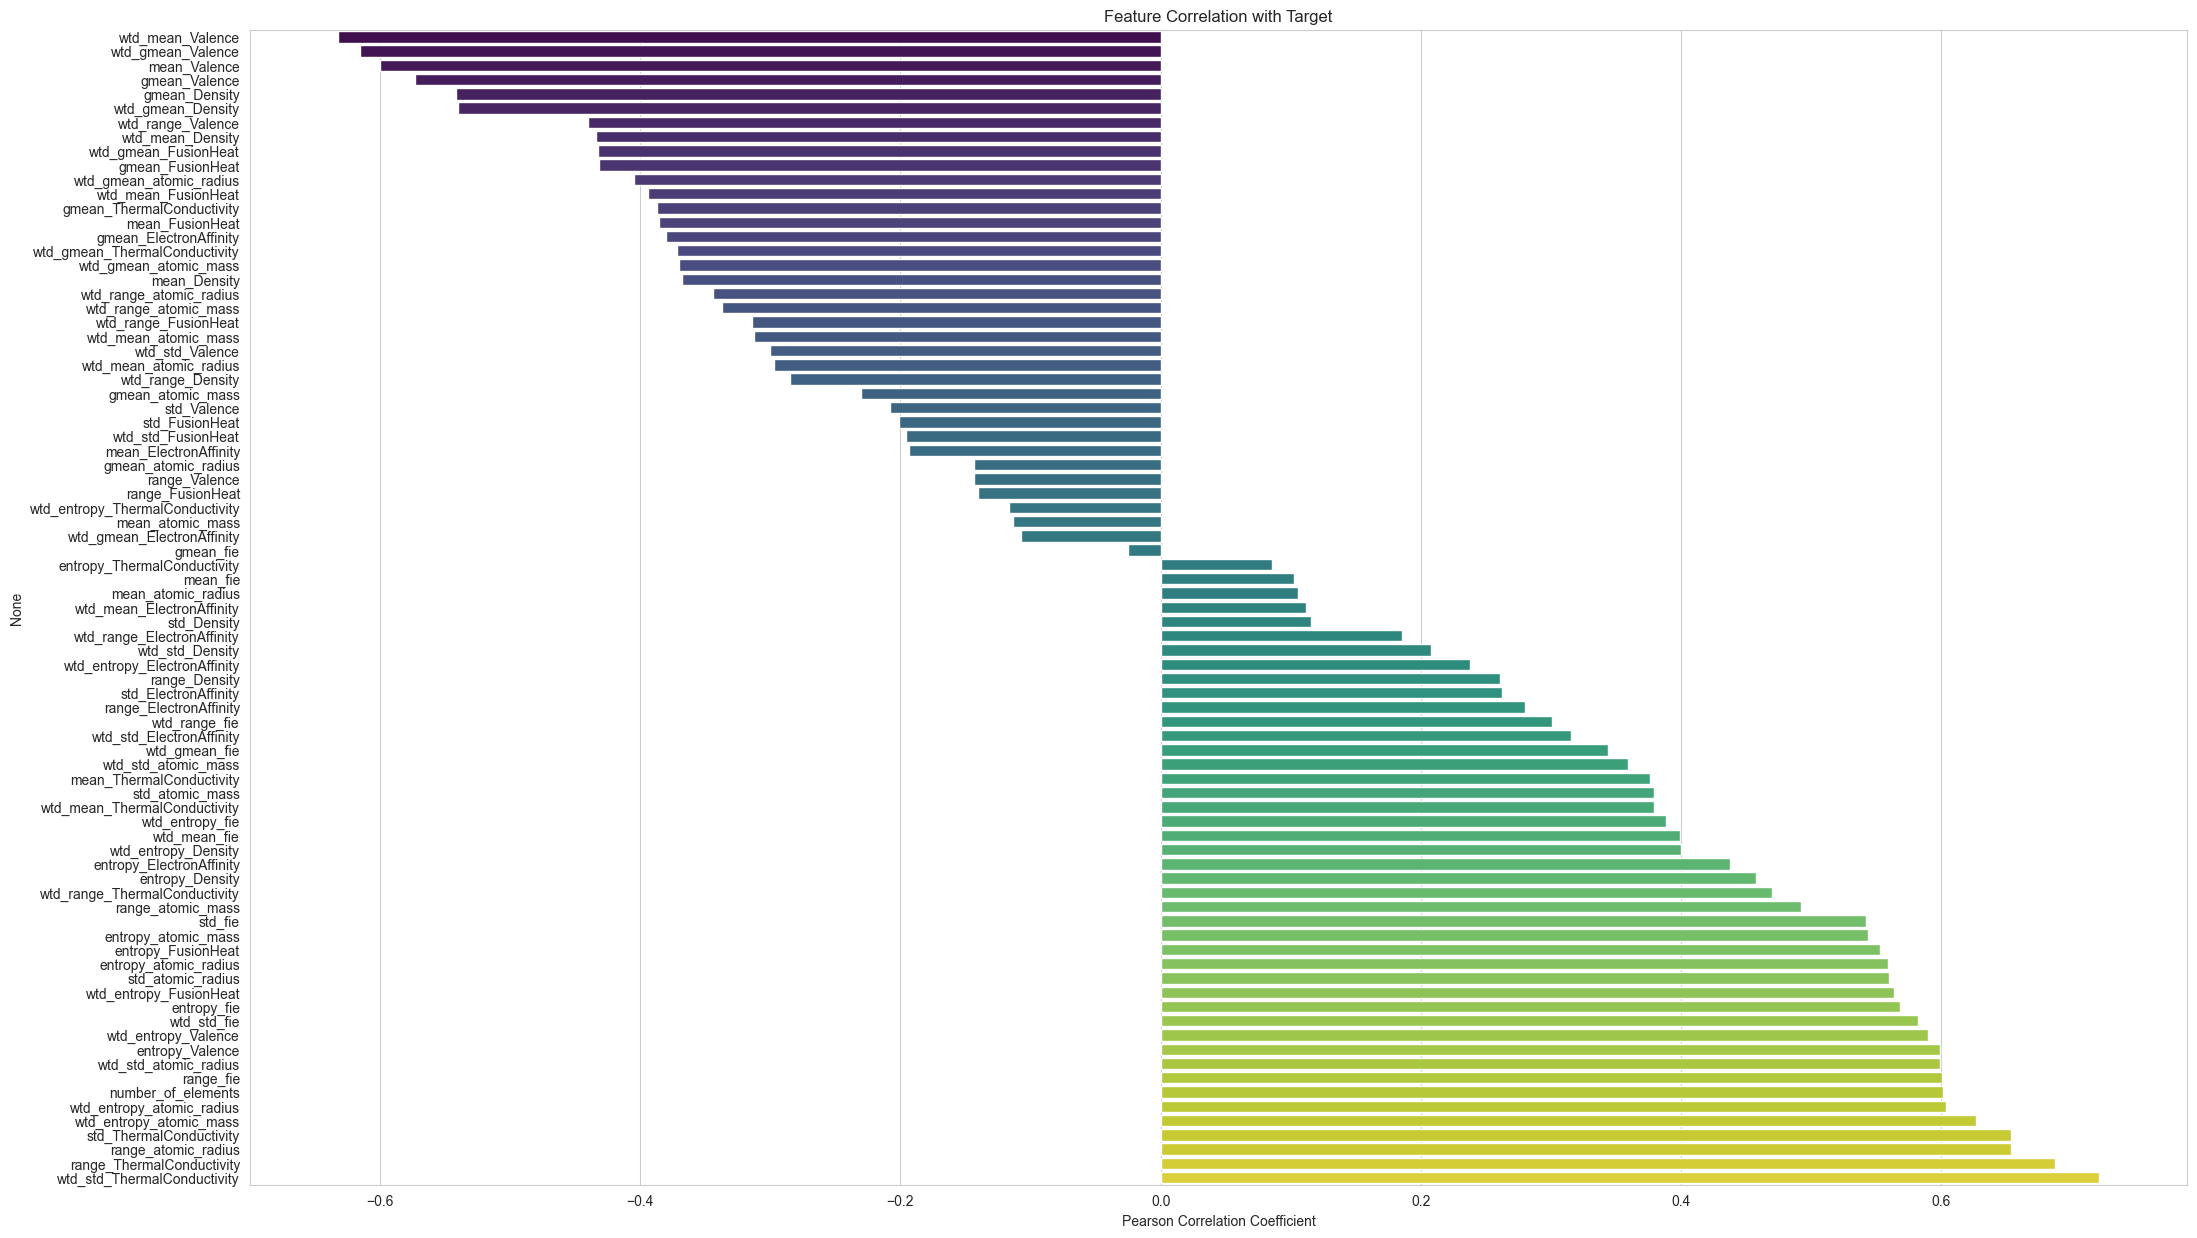


Selected 37 features:
['gmean_ThermalConductivity', 'entropy_ElectronAffinity', 'range_Density', 'mean_Density', 'std_ElectronAffinity', 'mean_FusionHeat', 'wtd_range_atomic_mass', 'wtd_range_Valence', 'std_ThermalConductivity', 'std_fie', 'range_ElectronAffinity', 'entropy_Density', 'std_Density', 'std_atomic_radius', 'wtd_mean_Valence', 'mean_ThermalConductivity', 'range_ThermalConductivity', 'wtd_gmean_Valence', 'wtd_std_ThermalConductivity', 'wtd_entropy_FusionHeat', 'gmean_ElectronAffinity', 'wtd_gmean_Density', 'entropy_Valence', 'gmean_FusionHeat', 'wtd_entropy_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 'wtd_mean_ThermalConductivity', 'entropy_FusionHeat', 'wtd_std_ElectronAffinity', 'entropy_atomic_radius', 'gmean_Density', 'std_atomic_mass', 'entropy_fie', 'gmean_atomic_mass', 'range_fie', 'mean_ElectronAffinity', 'entropy_atomic_mass']

Model Performance Comparison:
                      Model       RMSE        MAE        R2  CV RMSE (Mean)  \
3             Rando

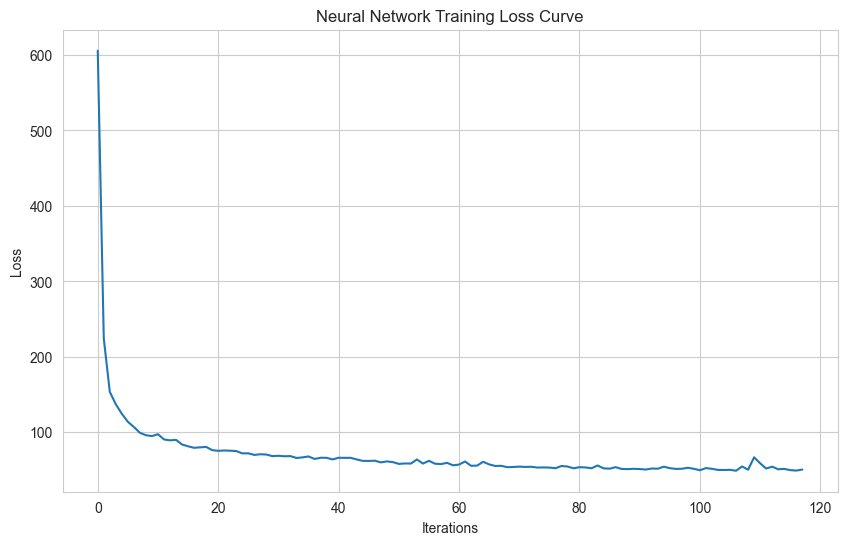

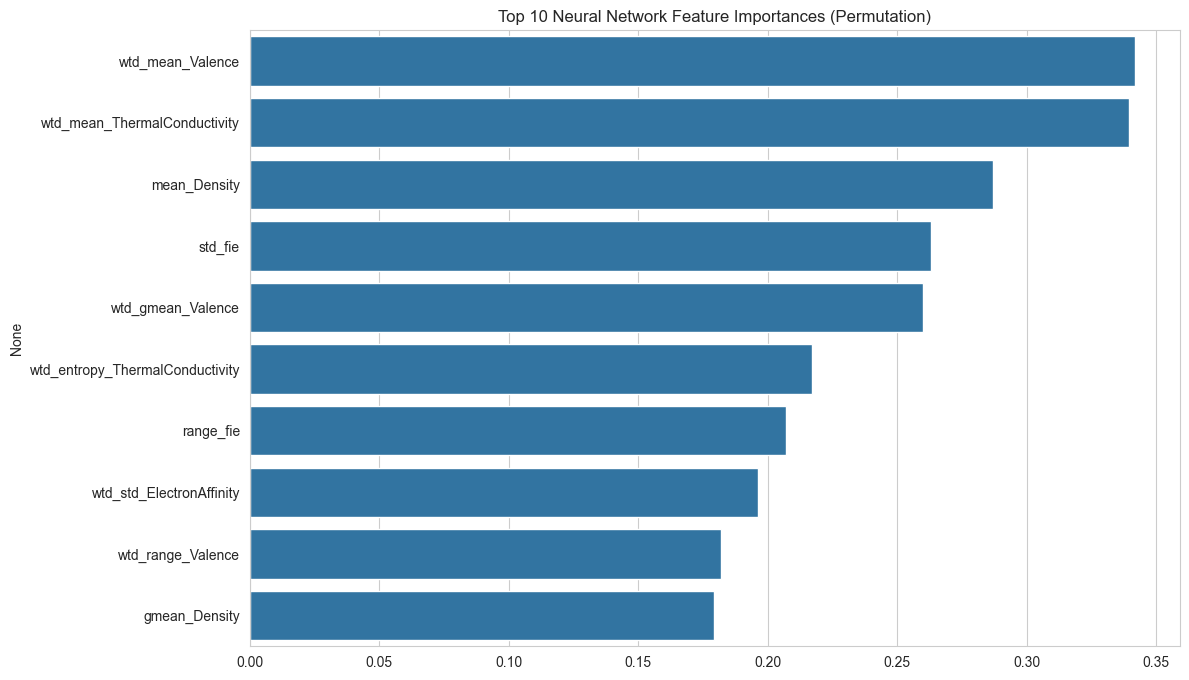


Ensemble Performance: RMSE=9.90, R²=0.92


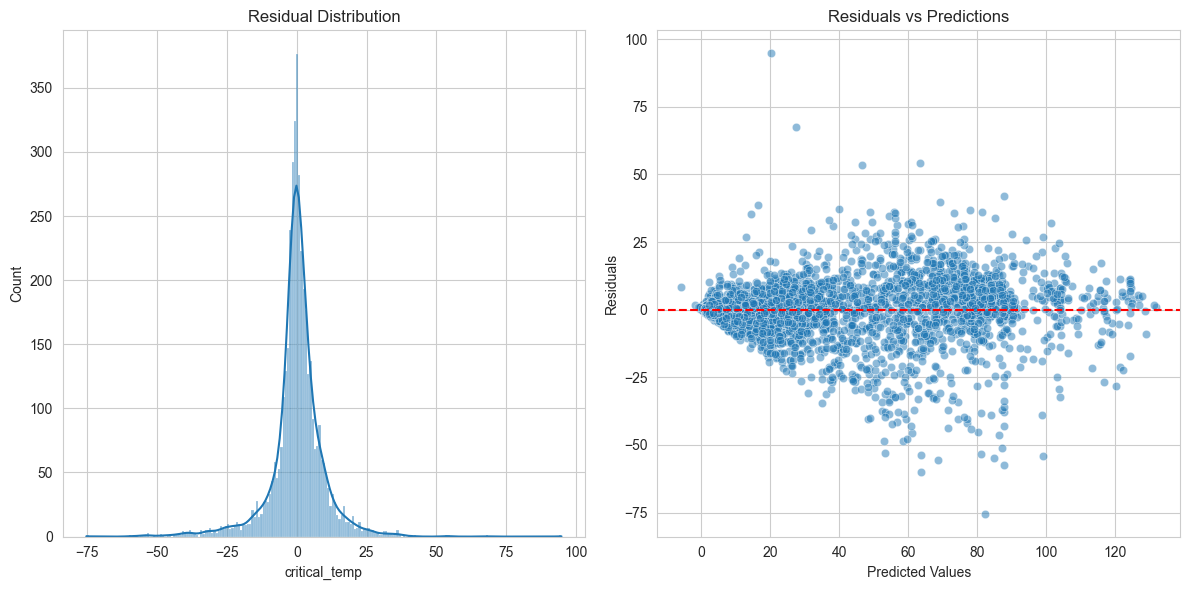


Models and preprocessing pipeline saved successfully


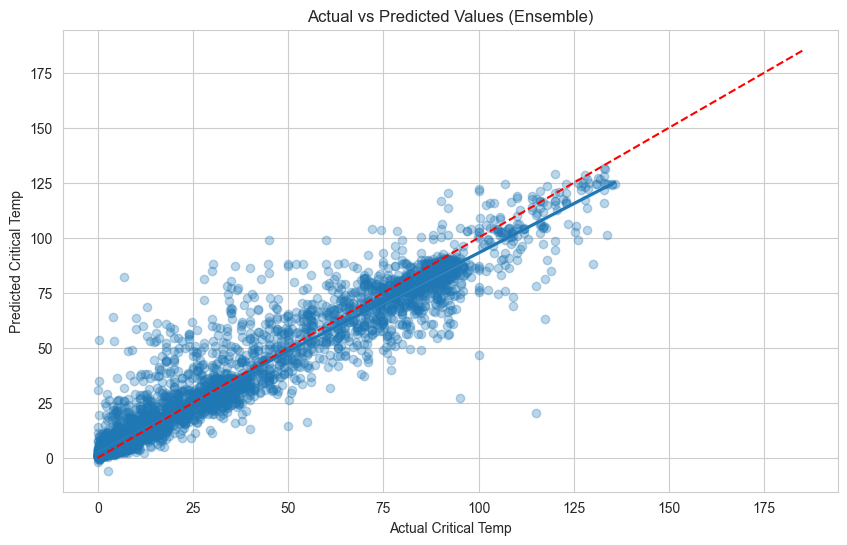

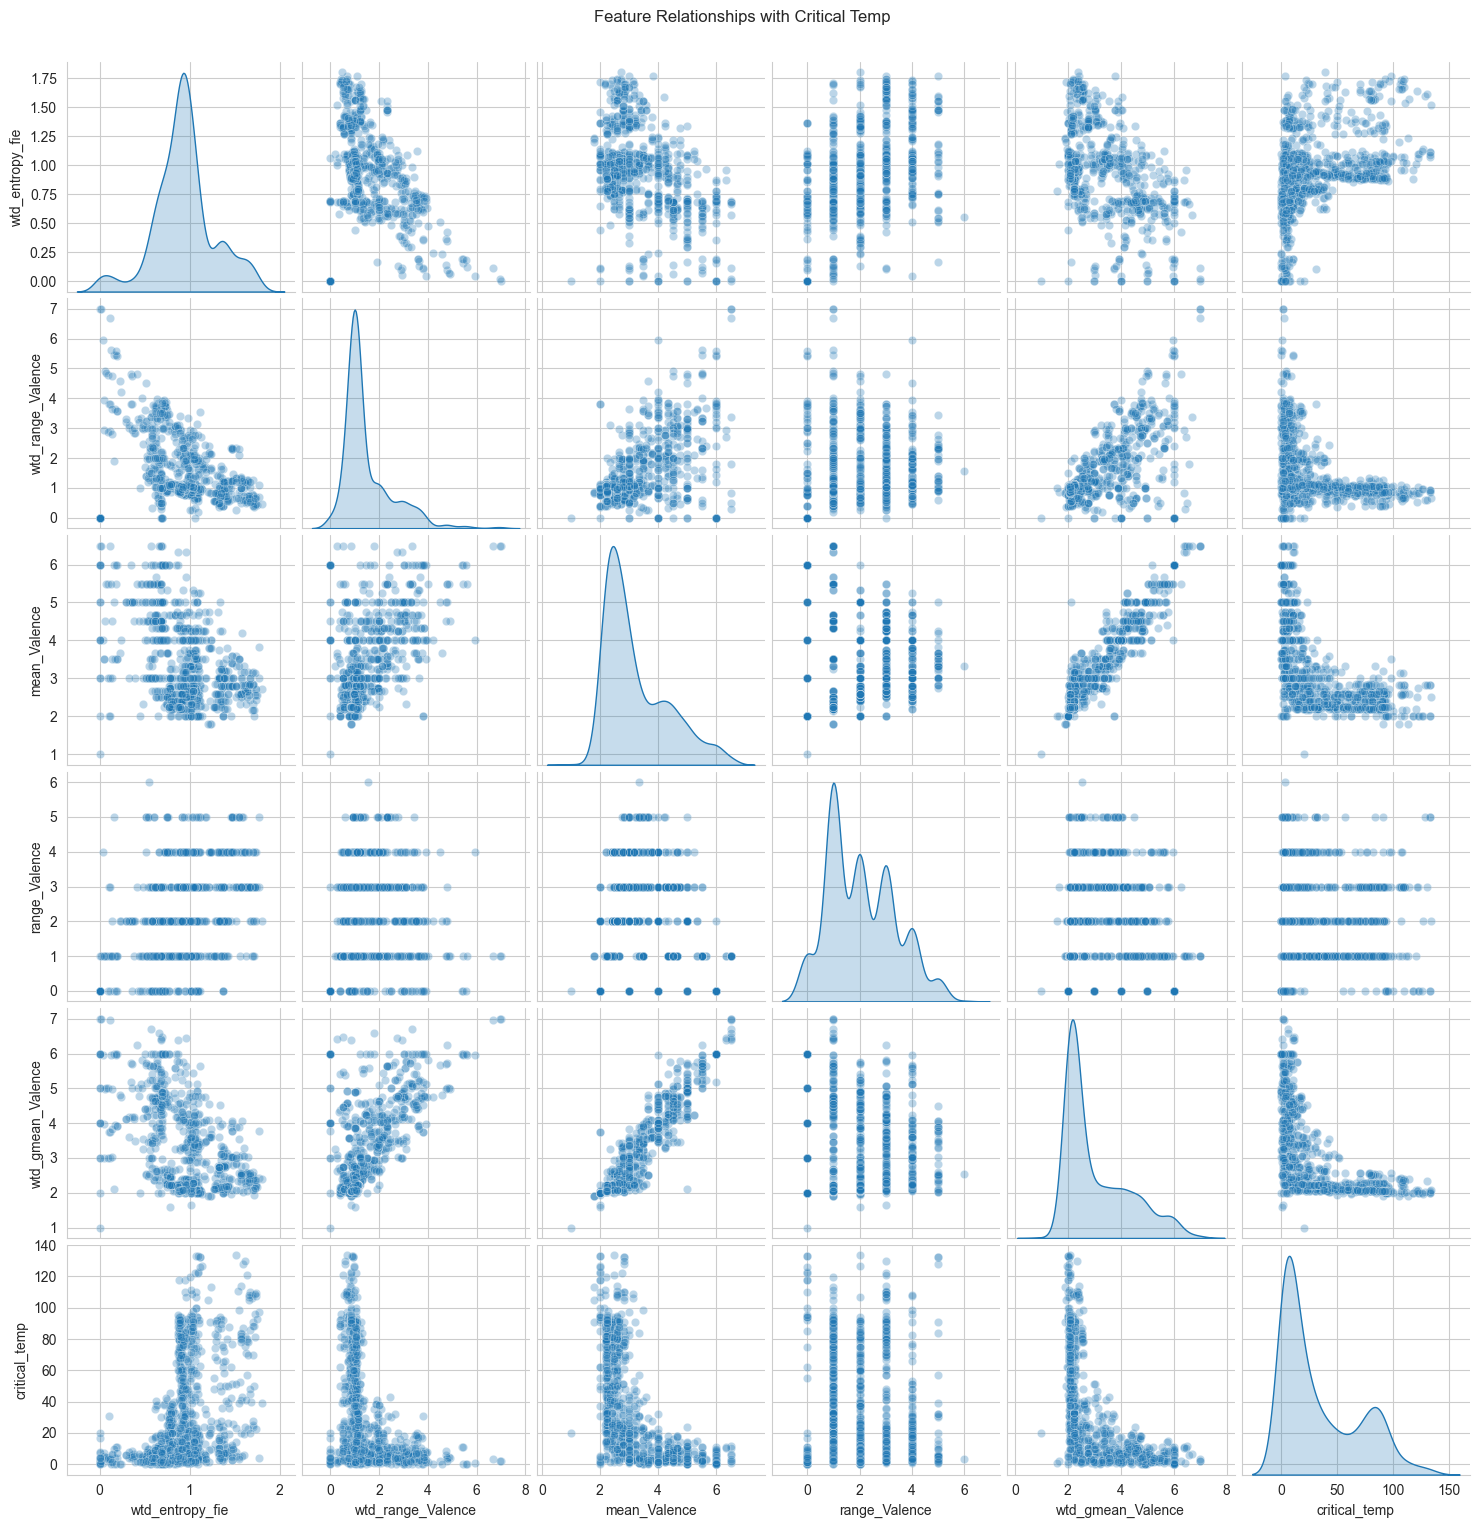

In [9]:
# %% Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import joblib
import time

# %% Data Loading and Initial Inspection
df = pd.read_csv('Superconductor.csv')
print("Initial Data Overview:")
print(f"Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes.value_counts())
print("\nMissing Values:")
print(df.isnull().sum().sum())  # Verify completeness

# %% Enhanced Exploratory Data Analysis
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Target Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['critical_temp'], kde=True, color='darkblue')
plt.title('Critical Temperature Distribution')
plt.xlabel('Critical Temp (K)')

# Boxplot Analysis
plt.subplot(2, 2, 2)
sns.boxplot(x=df['critical_temp'], color='lightgreen')
plt.title('Critical Temperature Spread')

# Feature Pairplot (Sample)
plt.subplot(2, 2, 3)
sns.scatterplot(x='number_of_elements',y='critical_temp', data=df, alpha=0.3)
plt.title('Example Feature Relationship')

plt.tight_layout()

# Feature Correlation
corr_with_target = df.corr()['critical_temp'].sort_values()[:-1]
plt.figure(figsize=(25, 15))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.title('Feature Correlation with Target')
plt.xlabel('Pearson Correlation Coefficient')
plt.show()



# %% Advanced Feature Selection
X = df.drop('critical_temp', axis=1)
y = df['critical_temp']

# Step 1: Mutual Information Selection
mi_selector = SelectKBest(mutual_info_regression, k=25)
X_mi = mi_selector.fit_transform(X, y)
mi_features = X.columns[mi_selector.get_support()]

# Step 2: Recursive Feature Elimination
rfe_selector = RFE(RandomForestRegressor(n_estimators=50), n_features_to_select=15)
X_rfe = rfe_selector.fit_transform(X, y)
rfe_features = X.columns[rfe_selector.get_support()]

# Combine selected features
selected_features = list(set(mi_features) | set(rfe_features))
print(f"\nSelected {len(selected_features)} features:")
print(selected_features)

X = X[selected_features]

# %% Data Preparation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, q=5)
)

# Advanced Preprocessing Pipeline
preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# %% Model Configuration
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'Neural Network': MLPRegressor(random_state=42)
}

# Hyperparameter Grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(100,), (50,50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001, 0.01]
    },
    'Support Vector Regressor': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

# %% Model Training and Tuning
results = []
best_models = {}

for name, model in models.items():
    start_time = time.time()
    
    # Hyperparameter Tuning
    if name in param_grids:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train_processed, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        best_model = model
        best_model.fit(X_train_processed, y_train)
        best_params = "No tuning"
    
    # Cross-Validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        best_model, X_train_processed, y_train,
        cv=cv, scoring='neg_root_mean_squared_error'
    )
    
    # Prediction and Evaluation
    best_model.fit(X_train_processed, y_train)
    y_pred = best_model.predict(X_test_processed)
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV RMSE (Mean)': -cv_scores.mean(),
        'CV RMSE (Std)': cv_scores.std(),
        'Training Time': time.time() - start_time,
        'Best Params': best_params
    })
    
    best_models[name] = best_model

# Results DataFrame
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\nModel Performance Comparison:")
print(results_df)

# %% Neural Network Analysis
nn_model = best_models['Neural Network']

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(nn_model.loss_curve_)
plt.title('Neural Network Training Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# Feature Importance (Permutation Importance)
nn_importance = permutation_importance(
    nn_model, X_test_processed, y_test,
    n_repeats=10, random_state=42
)

sorted_idx = nn_importance.importances_mean.argsort()[::-1]
plt.figure(figsize=(12, 8))
sns.barplot(x=nn_importance.importances_mean[sorted_idx][:10],
            y=X.columns[sorted_idx][:10])
plt.title('Top 10 Neural Network Feature Importances (Permutation)')
plt.show()

# %% Ensemble Model
ensemble = VotingRegressor([
    ('gb', best_models['Gradient Boosting']),
    ('rf', best_models['Random Forest']),
    ('nn', best_models['Neural Network'])
])

ensemble.fit(X_train_processed, y_train)
y_pred_ensemble = ensemble.predict(X_test_processed)

ensemble_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
ensemble_r2 = r2_score(y_test, y_pred_ensemble)

print(f"\nEnsemble Performance: RMSE={ensemble_rmse:.2f}, R²={ensemble_r2:.2f}")

# %% Error Analysis
residuals = y_test - y_pred_ensemble
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_ensemble, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# %% Model Persistence
joblib.dump(best_models, 'best_models.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
print("\nModels and preprocessing pipeline saved successfully")

# %% Prediction Error Plot
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_ensemble, scatter_kws={'alpha':0.3})
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.title('Actual vs Predicted Values (Ensemble)')
plt.xlabel('Actual Critical Temp')
plt.ylabel('Predicted Critical Temp')
plt.show()

# %% Feature Relationships Analysis
top_features = [
    'wtd_entropy_fie',
    'wtd_range_Valence',
    'mean_Valence',
    'range_Valence',
    'wtd_gmean_Valence'
]

sns.pairplot(df[top_features + ['critical_temp']].sample(1000),
             diag_kind='kde',
             plot_kws={'alpha':0.3})
plt.suptitle('Feature Relationships with Critical Temp', y=1.02)
plt.show()